In [1]:
import sys
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy.signal import welch
import seaborn as sns
import os
from pathlib import Path
sys.path.append('D:/capachinos')

In [2]:
from src.eeg_analysis.preprocessing.eeg_file import EEGFile
from src.eeg_analysis.preprocessing.eeg_preprocessor import EEGPreprocessor
from src.eeg_analysis.analysis.power_spectral import PowerSpectralAnalysis, TimeFrequencyRepresentation
from src.eeg_analysis.visualization.plots import plot_continuous_epochs
from src.eeg_analysis.visualization.my_custom_style import set_custom_style


participant_id = 1
base_dir = Path(r'D:\Anesthesia_Research_Fellow') / f'CA-{participant_id:02}'
base_path = base_dir / f'CA-{participant_id:02}'

vhdr_path = base_path.with_suffix('.vhdr')
vmrk_path = base_path.with_suffix('.vmrk')
eeg_path = base_path.with_suffix('.eeg')

eeg_file = EEGFile(participant_id, str(vhdr_path), str(vmrk_path), str(eeg_path))
eeg_file.load_data()

EEG Data Shape: (10477791, 21)


In [3]:
preprocessor = EEGPreprocessor(eeg_file)

target_fs = 250
window_size = 10
step_size = 5
order = 5
low_cutoff = 0.5
high_cutoff = 55
epoch_length = 30

sequence_of_operations = [
    ('downsample', {'target_fs': target_fs}),
    ('create_epochs', {'events_df': eeg_file.events_df}),
    # ('detrend', {'window_size': window_size, 'step_size': step_size}),
    # ('re_reference', {'reference_type': 'average'}),
    ('bandpass_filter', {'order': order,'low_cutoff': low_cutoff, 'high_cutoff': high_cutoff}),
    ('exclude_noisy_periods', {'window_size':2, 'threshold':10, 'min_num_channels':1, 'padding':'zeros'})
]
preprocessor.process(sequence_of_operations)

In [4]:
eeg_data = preprocessor.eeg_data['emergence']
sampling_rate = preprocessor.sampling_frequency

eeg_int = EEGPreprocessor.convert_to_neuroscope_eeg(eeg_data, eeg_path, sampling_rate)

In [5]:
power_spectral = PowerSpectralAnalysis(preprocessor, window_size=2, step_size=1) 

##### Calculate the time frequency representations 

In [6]:
select_epochs = ['preop_rest', 'pre_drug_infusion', 'emergence', 'pacu_rest']
power_spectral.calculate_time_frequency_map(select_channels = None, select_epochs=select_epochs, method='morlet')

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


D:\capachinos\src\eeg_analysis\analysis\power_spectral.py:63: RuntimeWarning: divide by zero encountered in log10
  Sxx_db = 10 * np.log10(np.abs(data_to_plot))
D:\capachinos\src\eeg_analysis\analysis\power_spectral.py:63: RuntimeWarning: divide by zero encountered in log10
  Sxx_db = 10 * np.log10(np.abs(data_to_plot))


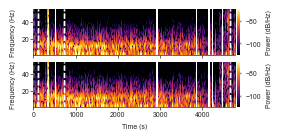

In [7]:
set_custom_style()

epochs_to_remove = [] #['pre_incision', 'pre_drug_infusion']
tfr_to_plot = power_spectral.tfr.copy()
for key in epochs_to_remove:
    tfr_to_plot.pop(key, None)

channels_to_plot = [0, 1]
num_channels = len(channels_to_plot)

# Define single-column or double_column width figure
fig_width = 4 #3.5 # for single_column figure
# fig_width = 7.2 # for double column figure
fig_height = 0.7*num_channels

font_size = 6

fig = plt.figure()
fig.set_size_inches([fig_width, fig_height])
gs = GridSpec(
    nrows=num_channels, 
    ncols=1, 
    figure=fig, 
    wspace = 0.15, 
    hspace = 0.15
)

for channel_idx in channels_to_plot:
    ax = fig.add_subplot(gs[channel_idx, 0])
    plot_continuous_epochs(tfr_to_plot, ax = ax, channel = channel_idx, vmin=-110, vmax=-70, cmap = 'inferno') 

    if channel_idx==channels_to_plot[-1]:
        ax.set_xlabel('Time (s)')
    else:
        ax.set_xticklabels([])
        
    ax.set_ylabel('Frequency (Hz)')
    ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=1)

plt.subplots_adjust(left=0.2, right= 0.8, bottom=0.2, top=0.9)

main_dir = f'D:/capachinos' 
filename = 'tfrs_channels.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()


##### Plot the average TFR for each anatomical region

In [8]:
power_spectral.postprocess_anatomical_region_average()

In [13]:
power_spectral.postprocess_frequency_domain_whitening(attr_name='region_average_tfr')

D:\capachinos\src\eeg_analysis\analysis\power_spectral.py:119: RuntimeWarning: divide by zero encountered in log10
  tfr_data_db = 10 * np.log10(np.abs(self.data))


In [9]:
power_spectral.postprocess_time_window_average(window_size=300, step_size=100, attr_name='region_average_tfr')

In [10]:
power_spectral.postprocess_aperiodic_paramaters(attr_name='window_average_tfr')

In [11]:
power_spectral.postprocess_periodic_parameters(attr_name='window_average_tfr', peak_threshold= 1.5, overlap_threshold=0.5)

D:\capachinos\src\eeg_analysis\analysis\power_spectral.py:63: RuntimeWarning: divide by zero encountered in log10
  Sxx_db = 10 * np.log10(np.abs(data_to_plot))
D:\capachinos\src\eeg_analysis\analysis\power_spectral.py:63: RuntimeWarning: divide by zero encountered in log10
  Sxx_db = 10 * np.log10(np.abs(data_to_plot))
D:\capachinos\src\eeg_analysis\analysis\power_spectral.py:63: RuntimeWarning: divide by zero encountered in log10
  Sxx_db = 10 * np.log10(np.abs(data_to_plot))
D:\capachinos\src\eeg_analysis\analysis\power_spectral.py:63: RuntimeWarning: divide by zero encountered in log10
  Sxx_db = 10 * np.log10(np.abs(data_to_plot))
D:\capachinos\src\eeg_analysis\analysis\power_spectral.py:63: RuntimeWarning: divide by zero encountered in log10
  Sxx_db = 10 * np.log10(np.abs(data_to_plot))
D:\capachinos\src\eeg_analysis\analysis\power_spectral.py:63: RuntimeWarning: divide by zero encountered in log10
  Sxx_db = 10 * np.log10(np.abs(data_to_plot))


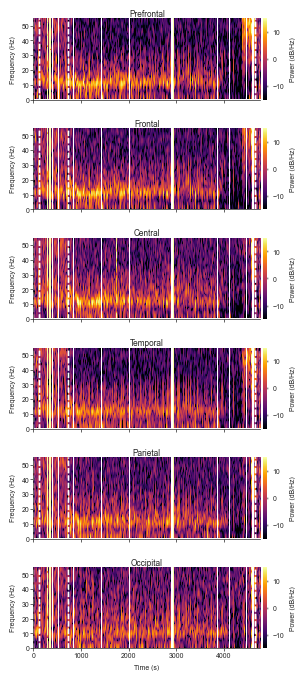

In [14]:
region_average_tfr = power_spectral.region_average_tfr
num_regions = len(region_average_tfr)

set_custom_style()

epochs_to_remove = [] #['pre_incision', 'pre_drug_infusion']
tfr_to_plot = power_spectral.tfr.copy()
for key in epochs_to_remove:
    tfr_to_plot.pop(key, None)

# freq_bands = power_spectral.fooof_periodic_parameters['prefrontal'][select_epochs[0]].keys()


# Define single-column or double_column width figure
fig_width = 4.5 #3.5 # for single_column figure
# fig_width = 7.2 # for double column figure
fig_height = 1.5*num_regions

font_size = 6

fig = plt.figure()
fig.set_size_inches([fig_width, fig_height])
gs = GridSpec(
    nrows=num_regions, 
    ncols=1, 
    figure=fig, 
    wspace = 0.15, 
    hspace = 0.35
)

region_count = 0
for region, tfr in power_spectral.whitened_tfr.items(): # region_average_tfr
    ax = fig.add_subplot(gs[region_count, 0])
    plot_continuous_epochs(tfr, ax=ax,  vmin=-15, vmax=15, cmap='inferno', title=region) # vmin=-110, vmax=-70

    if region == list(region_average_tfr.keys())[-1]:
        ax.set_xlabel('Time (s)')
    else:
        ax.set_xticklabels([])
        
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(region.capitalize(), pad=1)

    
    # for band in freq_bands:
    start_shift = 0
    for epoch in select_epochs:
        window_centers = start_shift + power_spectral.window_average_tfr[region][epoch].times

        # freq_band_info = power_spectral.fooof_periodic_parameters[region][epoch][band]
        # cf = freq_band_info['cf'][0]
        # lower_bound = freq_band_info['lower_bound'][0]
        # upper_bound = freq_band_info['upper_bound'][0]
        
        # # ax.plot(window_centers, cf, linestyle='-', linewidth=0.2, color='w')
        # # ax.plot(window_centers, lower_bound, linestyle=':', linewidth=0.2, color='w')  # Dotted line style
        # # ax.plot(window_centers, upper_bound, linestyle=':', linewidth=0.2, color='w')  # Dotted line style

        start_shift += power_spectral.tfr[epoch].times[-1]

    ax.set_xticks(range(0, int(window_centers[-1]), 1000))
    ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=1)

    ax.set_ylim([0, 55])
    ax.set_yticks(range(0, 56, 10))
    region_count += 1

plt.subplots_adjust(left=0.2, right= 0.8, bottom=0.2, top=0.9)

main_dir = f'D:/capachinos' 
filename = 'tfrs_regions.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

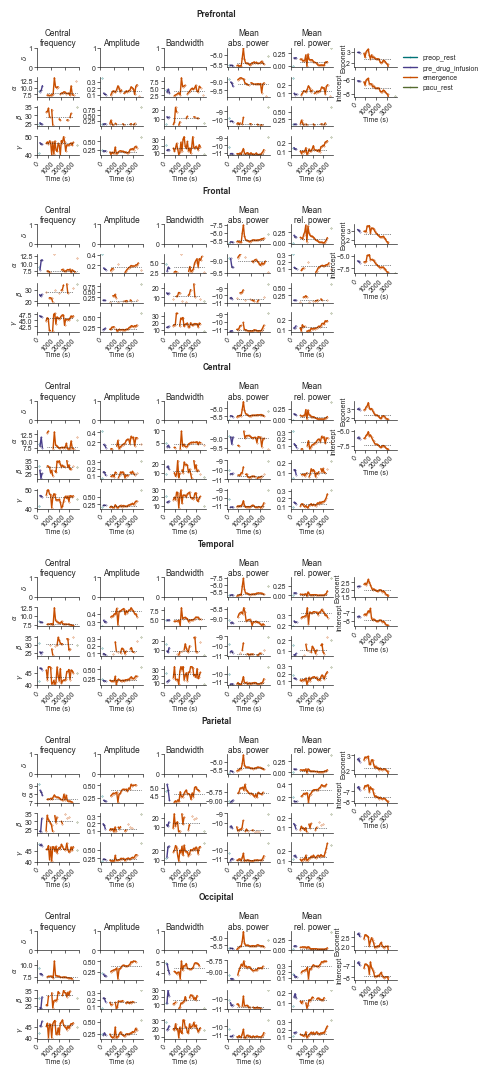

In [29]:
regions = ['prefrontal', 'frontal', 'central', 'temporal', 'parietal', 'occipital']
epochs = select_epochs
frequency_bands = ['delta', 'alpha', 'beta', 'gamma']
periodic_features = ['cf', 'amplitude', 'bw', 'avg_power_absolute', 'avg_power_relative']
aperiodic_features = ['exponents', 'intercepts']
num_regions = len(regions)
num_bands = len(frequency_bands)
num_periodic_features = len(periodic_features)
num_aperiodic_features = len(aperiodic_features)

epoch_colors = ['#007377', '#483D8B', '#C84E00', '#556B2F']

greek_band_names = {
    'delta': r'$\delta$',
    'alpha': r'$\alpha$',
    'beta': r'$\beta$',
    'gamma': r'$\gamma$'
}

full_feature_names = {
    'cf': 'central\nfrequency',
    'amplitude': 'amplitude',
    'bw': 'bandwidth',
    'avg_power_relative': 'mean\nrel. power',
    'avg_power_absolute': 'mean\nabs. power'
}

# Calculate an approximate figure height
fig_width = 6  # inches
fig_height = 2 * num_regions + 0.5 * num_regions  # inches (additional space for region titles)

font_size = 6  # font size for the titles

# Create a figure
fig = plt.figure()
fig.set_size_inches([fig_width, fig_height])
gs = GridSpec(
    nrows=num_regions * (num_bands + 2),  # accounting for extra title rows
    ncols=num_periodic_features+1,
    figure=fig,
    wspace=0.5, 
    hspace=0.5
)

# Loop through each region, band, and feature to create plots
for r_idx, region in enumerate(regions):
    # Create an empty axis for the supertitle of the region
    ax_title = fig.add_subplot(gs[r_idx * (num_bands + 2), :])  # Span all columns
    ax_title.set_title(region.capitalize(), fontsize=font_size, fontweight='bold', pad=0)
    ax_title.axis('off')  # Hide the axis for the region title
    
    for b_idx, band in enumerate(frequency_bands):
        for f_idx, feature in enumerate(periodic_features):
            # Adjust the row index by adding 1 to account for the region title row
            ax = fig.add_subplot(gs[r_idx * (num_bands + 2) + b_idx + 1, f_idx])
            
            # Example data retrieval and plotting (replace accordingly)
            start_shift = 0
            for epoch_idx, epoch in enumerate(epochs):
                parameter_data = power_spectral.fooof_periodic_parameters[region][epoch][band][feature][0]
                window_centers = start_shift + power_spectral.window_average_tfr[region][epoch].times
                start_shift += power_spectral.tfr[epoch].times[-1]

                # Plot the data on the subplot
                if not np.all(np.isnan(parameter_data)):
                    ax.plot(window_centers, parameter_data, linewidth=1, color=epoch_colors[epoch_idx], marker='.', markersize=.5)
                    ax.plot(window_centers, [np.nanmedian(parameter_data)]*len(window_centers), linewidth=0.5, linestyle=':', color='k')
                    
                    # Set a dashed vertical line to indicate a change of period
                    # ax.axvline(x=start_shift, color='grey', linestyle='--', linewidth=0.5)

            ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=1)
            ax.set_xticks(range(0, int(window_centers[-1]), 1000))
            ax.set_xticklabels(ax.get_xticks(), rotation=45)

            # Label the subplot if it's the first column or the last row within a region
            if f_idx == 0:
                ax.set_ylabel(f'{greek_band_names[band]}', labelpad=0)
            if b_idx == num_bands - 1:
                ax.set_xlabel('Time (s)', labelpad=0)
            if b_idx != num_bands - 1:
                ax.set_xticklabels([])
            if b_idx == 0:
                ax.set_title(f'{full_feature_names[feature].capitalize()}', pad=0)
            

    # Now let's add the exponents and intercepts plots at the end of each region's row span
    # Plot exponents in the next-to-last column
    for ap_idx, aperodic_param in enumerate(aperiodic_features):
        ax = fig.add_subplot(gs[r_idx * (num_bands + 2) + ap_idx+1, -1])

        start_shift = 0
        for epoch_idx, epoch in enumerate(epochs):
            parameter_data = power_spectral.fooof_aperiodic_parameters[region][epoch][aperodic_param][0]
            window_centers = start_shift + power_spectral.window_average_tfr[region][epoch].times
            start_shift += power_spectral.tfr[epoch].times[-1]

            ax.plot(window_centers, parameter_data, linewidth=1, color=epoch_colors[epoch_idx], label=epoch, marker='.', markersize=.5)
            ax.plot(window_centers, [np.nanmedian(parameter_data)]*len(window_centers), linewidth=0.5, linestyle=':', color='k')

            # ax.axvline(x=start_shift, color='grey', linestyle='--', linewidth=0.5)
    
        ax.set_ylabel(aperodic_param[:-1].capitalize(), labelpad=0)
        ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=1)
        ax.set_xticks(range(0, int(window_centers[-1]), 1000))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)

        ylim = ax.get_ylim()
        emergence_data = power_spectral.fooof_aperiodic_parameters[region]['emergence'][aperodic_param][0]
        ax.set_ylim([np.nanpercentile(emergence_data, 10), ylim[1]])

        if ap_idx == num_aperiodic_features - 1:
            ax.set_xlabel('Time (s)', labelpad=0)
        if ap_idx != num_aperiodic_features - 1:
            ax.set_xticklabels([])

        if (r_idx == 0) and (ap_idx == 0):
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Adjust layout
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.9)
# Save plot
main_dir = 'D:/capachinos'
filename = 'fooof_features.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)
# Show plot
plt.show()

In [17]:
power_spectral.fooof_aperiodic_parameters[region]['pacu_rest']['exponents'][0]

array([2.5531902])

##### Power spectral densities calculated by averaging the TFRs 

In [ ]:
# epochs_to_remove = ['pre_preop_rest', 'pre_incision', 'pre_drug_infusion']
# tfr_to_plot = power_spectral.tfr.copy()
# for key in epochs_to_remove:
#     tfr_to_plot.pop(key, None)
tfr_to_plot = power_spectral.whitened_tfr['prefrontal']

frequencies = tfr_to_plot['emergence'].frequencies

plt.figure(figsize=(10, 7))

# Iterate over all epochs
for epoch_name in tfr_to_plot.keys():
    # Compute the mean spectral power with outlier removal for the current epoch
    psd, std = TimeFrequencyRepresentation._calculate_mean_spectral_power_with_outlier_removal(tfr_to_plot[epoch_name].data)
    
    # Convert the power to decibels
    psd_db = 10 * np.log10(psd)
    std_db = 10 * np.log10(psd + std) - psd_db  # Convert std to dB as well
    
    # Plot the mean spectral power for the current epoch in dB
    plt.plot(frequencies, psd_db, label=epoch_name)
    plt.fill_between(frequencies, psd_db - std_db, psd_db + std_db, alpha=0.2)

# Set the x-axis to logarithmic scale
# plt.xscale('log') #log is log10

# To enhance figure aesthetics you may add x and y labels, title, and legend if desired
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mean Spectral Power (dB)')
plt.title('Mean Spectral Power across Epochs')
plt.legend(fontsize = 18)

# Show the figure with a logarithmic frequency axis
plt.show()

##### Whitening in frequency domain

In [ ]:
power_spectral.postprocess_frequency_domain_whitening()

In [ ]:
epochs_to_remove = ['pre_incision', 'pre_drug_infusion']
tfr_to_plot = power_spectral.whitened_tfr.copy()
for key in epochs_to_remove:
    tfr_to_plot.pop(key, None)

plot_continuous_epochs(tfr_to_plot, vmin=-7, vmax=11, cmap = 'inferno')

In [ ]:
epochs_to_remove = ['pre_preop_rest', 'pre_incision', 'pre_drug_infusion']
tfr_to_plot = power_spectral.whitened_tfr.copy()
for key in epochs_to_remove:
    tfr_to_plot.pop(key, None)

frequencies = tfr_to_plot['preop_rest'].frequencies

plt.figure(figsize=(10, 7))

# Iterate over all epochs
for epoch_name in tfr_to_plot.keys():
    # Compute the mean spectral power with outlier removal for the current epoch
    psd, std, _ = tfr_to_plot[epoch_name]._get_mean_spectral_power_with_outlier_removal()
    
    # Convert the power to decibels
    psd_db = 10 * np.log10(psd)
    std_db = 10 * np.log10(psd + std) - psd_db  # Convert std to dB as well
  
    # Plot the mean spectral power for the current epoch in dB
    plt.plot(frequencies, psd_db, label=epoch_name)
    plt.fill_between(frequencies, psd_db - std_db, psd_db + std_db, alpha=0.3)

# Set the x-axis to logarithmic scale
# plt.xscale('log') #log is log10

# To enhance figure aesthetics you may add x and y labels, title, and legend if desired
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mean Spectral Power (dB)')
plt.title('Mean Spectral Power across Epochs')
plt.legend(fontsize = 18)

# Show the figure with a logarithmic frequency axis
plt.show()

##### Whitening in the time domain

In [ ]:
power_spectral.preprocess_time_domain_whitening(baseline_epoch_name=None, window_size=10*power_spectral.sampling_frequency, coeff_mode='separate') 

In [ ]:
sfreq = power_spectral.sampling_frequency
nperseg = 128  # Number of data points per segment
noverlap = 64  # Number of points to overlap between segments

epoch_name = 'maintenance'
channel = 8

plt.figure(figsize=(15, 5))

# Create a gridspec to specify the relative widths of the subplots
gs = plt.GridSpec(1, 2, width_ratios=[3, 1])

# Use the first subplot for the raw signal waveforms (75% of the width)
ax1 = plt.subplot(gs[0])
ax1.plot(power_spectral.whitened_eeg[epoch_name][:500, channel], label='Whitened EEG')
ax1.plot(power_spectral.eeg_data[epoch_name][:500, channel], label='EEG Data')
ax1.set_title('Raw Waveforms')
ax1.legend()

# Use the second subplot for the PSDs (25% of the width)
ax2 = plt.subplot(gs[1])

# Compute the frequency and PSD using Welch's method
f_whitened, Pxx_whitened = welch(power_spectral.whitened_eeg[epoch_name][:, channel],
                                 fs=sfreq, nperseg=nperseg, noverlap=noverlap, scaling='spectrum')  # replace fs with your actual sampling frequency
f_eeg, Pxx_eeg = welch(power_spectral.eeg_data[epoch_name][:, channel],
                       fs=sfreq, nperseg=nperseg, noverlap=noverlap, scaling='spectrum')  # replace fs with your actual sampling frequency
max_freq = 50  # set your desired max frequency here

# Find the index where the frequency is just above the max frequency
idx_max_whitened = np.where(f_whitened > max_freq)[0][0]
idx_max_eeg = np.where(f_eeg > max_freq)[0][0]

# Plotting the PSD up to the maximum frequency only
ax2.semilogy(f_whitened[:idx_max_whitened], Pxx_whitened[:idx_max_whitened], label='Whitened EEG PSD')
ax2.semilogy(f_eeg[:idx_max_eeg], Pxx_eeg[:idx_max_eeg], label='EEG Data PSD')

ax2.set_title('Power Spectral Densities')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()